<a href="https://colab.research.google.com/github/ersozbasak/Machine-Learning-Regression-Models/blob/master/7_Optimization_of_PJM_DATA_GRUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

EVALUATION OF PJM VALUES

1. Introduction and Integration (Regularization the Data Set)
2. Machine Learning Integration
3. Deep Learning Integration


### Regularization the Data Set

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
#mpl.rcParams['figure.figsize'] = (17, 5)
#mpl.rcParams['axes.grid'] = False
#sns.set_style("whitegrid")
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf
import csv

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/PJM_Values
%ls

/content/drive/MyDrive/PJM_Values
KNN_PJM_dataset.csv                rt_hrl_lmps_MARCH_MAY.csv
LSTM_PJM/                          rt_hrl_lmps_SEP_NOV.csv
rt_hrl_lmps_22JUNE_23JUNE_ALL.csv  structured_data_classifier/
rt_hrl_lmps_DEC_FEB.csv            structured_data_regressor/
rt_hrl_lmps_JUNE_AGU.csv


In [ ]:
df_22JUNE_23JUNE_ALL = pd.read_csv('/content/drive/MyDrive/PJM_Values/rt_hrl_lmps_22JUNE_23JUNE_ALL.csv',engine='python',encoding='utf-8')
df_JUNE_AGU = pd.read_csv('/content/drive/MyDrive/PJM_Values/rt_hrl_lmps_JUNE_AGU.csv',engine='python',encoding='utf-8')
df_SEP_NOV = pd.read_csv('/content/drive/MyDrive/PJM_Values/rt_hrl_lmps_SEP_NOV.csv',engine='python',encoding='utf-8')
df_DEC_FEB = pd.read_csv('/content/drive/MyDrive/PJM_Values/rt_hrl_lmps_DEC_FEB.csv',engine='python',encoding='utf-8')
df_MARCH_MAY = pd.read_csv('/content/drive/MyDrive/PJM_Values/rt_hrl_lmps_MARCH_MAY.csv',engine='python',encoding='utf-8')

In [ ]:
"""lmp_DEC_FEB = df_DEC_FEB[df_DEC_FEB['VALUE'].isin(['LMP'])]
lmp_MARCH_MAY = df_MARCH_MAY[df_MARCH_MAY['VALUE'].isin(['LMP'])]
lmp_JUNE_AGU = df_JUNE_AGU[df_JUNE_AGU['VALUE'].isin(['LMP'])]
lmp_SEP_NOV = df_SEP_NOV[df_SEP_NOV['VALUE'].isin(['LMP'])]
loadzone_DEC_FEB = lmp_DEC_FEB[lmp_DEC_FEB['TYPE'].isin(['Loadzone'])]
loadzone_MARCH_MAY = lmp_MARCH_MAY[lmp_MARCH_MAY['TYPE'].isin(['Loadzone'])]
loadzone_JUNE_AGU = lmp_JUNE_AGU[lmp_JUNE_AGU['TYPE'].isin(['Loadzone'])]
loadzone_SEP_NOV = lmp_SEP_NOV[lmp_SEP_NOV['TYPE'].isin(['Loadzone'])]"""

"lmp_DEC_FEB = df_DEC_FEB[df_DEC_FEB['VALUE'].isin(['LMP'])]\nlmp_MARCH_MAY = df_MARCH_MAY[df_MARCH_MAY['VALUE'].isin(['LMP'])]\nlmp_JUNE_AGU = df_JUNE_AGU[df_JUNE_AGU['VALUE'].isin(['LMP'])]\nlmp_SEP_NOV = df_SEP_NOV[df_SEP_NOV['VALUE'].isin(['LMP'])]\nloadzone_DEC_FEB = lmp_DEC_FEB[lmp_DEC_FEB['TYPE'].isin(['Loadzone'])]\nloadzone_MARCH_MAY = lmp_MARCH_MAY[lmp_MARCH_MAY['TYPE'].isin(['Loadzone'])]\nloadzone_JUNE_AGU = lmp_JUNE_AGU[lmp_JUNE_AGU['TYPE'].isin(['Loadzone'])]\nloadzone_SEP_NOV = lmp_SEP_NOV[lmp_SEP_NOV['TYPE'].isin(['Loadzone'])]"

In [ ]:
grouped_df_ALL = df_22JUNE_23JUNE_ALL.groupby('pnode_name')# Group HUB dataframe by the 'pnode_name' column
group_names_jm = grouped_df_ALL.groups.keys()# Get the names of each group = 12

In [ ]:
len(group_names_jm)

12

In [ ]:
df_list_22_23 = [ df_22JUNE_23JUNE_ALL]

for i in df_list_22_23:
    i.drop('datetime_beginning_utc', inplace=True, axis=1)
    i.drop('datetime_beginning_ept', inplace=True, axis=1)
    i.drop('pnode_id', inplace=True, axis=1)
    i.drop('voltage', inplace=True, axis=1)
    i.drop('equipment', inplace=True, axis=1)
    i.drop('type', inplace=True, axis=1)
    i.drop('zone', inplace=True, axis=1)
    i.drop('congestion_price_rt', inplace=True, axis=1)
    i.drop('marginal_loss_price_rt', inplace=True, axis=1)
    i.drop('system_energy_price_rt', inplace=True, axis=1)
    i.drop('row_is_current', inplace=True, axis=1)
    i.drop('version_nbr', inplace=True, axis=1)

In [ ]:
print(df_22JUNE_23JUNE_ALL.dtypes)

pnode_name       object
total_lmp_rt    float64
dtype: object


In [ ]:
df_22JUNE_23JUNE_ALL.head()

,pnode_name,total_lmp_rt
0,EASTERN HUB,69.669366
1,WEST INT HUB,67.783333
2,WESTERN HUB,68.755145
3,NEW JERSEY HUB,69.168388
4,CHICAGO GEN HUB,65.559705


In [ ]:
common_nodes = set(df_22JUNE_23JUNE_ALL['pnode_name'].unique())
df_22JUNE_23JUNE_ALL_filtered=df_22JUNE_23JUNE_ALL[df_22JUNE_23JUNE_ALL['pnode_name'].isin(common_nodes)]


In [ ]:
df_22JUNE_23JUNE_ALL_filtered

,pnode_name,total_lmp_rt
0,EASTERN HUB,69.669366
1,WEST INT HUB,67.783333
2,WESTERN HUB,68.755145
3,NEW JERSEY HUB,69.168388
4,CHICAGO GEN HUB,65.559705
...,...,...
105415,AEP GEN HUB,17.748531
105416,AEP-DAYTON HUB,18.123747
105417,OHIO HUB,18.155619
105418,DOMINION HUB,18.230117


In [ ]:
count_nan=df_22JUNE_23JUNE_ALL_filtered.isnull().sum()
# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: pnode_name      0
total_lmp_rt    0
dtype: int64


In [ ]:
grouped_df = df_22JUNE_23JUNE_ALL_filtered.groupby('pnode_name')# Group the loadzone_2016 dataframe by the 'NODE' column
group_names = grouped_df.groups.keys()# Get the names of each group
len(group_names)

12

In [ ]:
# group the merged_df dataframe by the 'NODE' column
grouped_df = df_22JUNE_23JUNE_ALL_filtered.groupby('pnode_name')

# get the names of each group
group_names = grouped_df.groups.keys()

node_list = []

# iterate through the grouped dataframe, get each group by its name, and append it to the node_list
for key, item in grouped_df:
    node_df = grouped_df.get_group(key)
    node_list.append(node_df)

stacked_df = []

# iterate through the node_list, drop the 'NODE' column, stack the dataframe, and append it to the stacked_df
for i in node_list:
    i_drop = i.drop('pnode_name', axis=1)
    s_df = i_drop.stack().reset_index(drop=True)
    stacked_df.append(s_df)

node_dfs = {}
df_list = []

# iterate through the group_names, create a dataframe for each node, and append it to the df_list
for i, node in enumerate(group_names):
    node_dfs[node] = pd.DataFrame(stacked_df[i], columns=[node])
    df_list.append(node_dfs[node])

# concatenate the dataframes in the df_list along the columns to get the final dataframe
df_all_2223 = pd.concat(df_list, axis=1)

In [ ]:
df_all_2223.head()

,AEP GEN HUB,AEP-DAYTON HUB,ATSI GEN HUB,CHICAGO GEN HUB,CHICAGO HUB,DOMINION HUB,EASTERN HUB,N ILLINOIS HUB,NEW JERSEY HUB,OHIO HUB,WEST INT HUB,WESTERN HUB
0,66.526689,68.095556,67.318277,65.559705,66.693074,69.495414,69.669366,66.248896,69.168388,68.268067,67.783333,68.755145
1,73.990110,75.501068,74.708125,72.656474,73.844903,77.405280,77.793004,73.368035,77.122941,75.629564,75.400555,76.753895
2,55.928728,56.996921,56.571705,54.765039,55.588311,58.358574,58.999558,55.258335,58.545221,57.086478,57.017916,58.048027
3,52.131930,53.100233,52.694148,51.074570,51.790448,54.294922,54.701800,51.508351,54.240732,53.176826,53.095880,53.991960
4,51.751316,52.390917,51.786250,49.386083,50.045211,53.740003,53.799772,49.809685,53.344182,52.374108,52.381388,53.275979


In [ ]:
count_nan = df_all_2223.isnull().sum()
print('Number of NaN values present: ' + str(count_nan))


Number of NaN values present: AEP GEN HUB        0
AEP-DAYTON HUB     0
ATSI GEN HUB       0
CHICAGO GEN HUB    0
CHICAGO HUB        0
DOMINION HUB       0
EASTERN HUB        0
N ILLINOIS HUB     0
NEW JERSEY HUB     0
OHIO HUB           0
WEST INT HUB       0
WESTERN HUB        0
dtype: int64


In [ ]:
# Save the modified dataset as a new CSV file
save_path ='/content/drive/MyDrive/New_PJM_ML/KNN/df_all_2223_KNN'
df_all_2223.to_csv(save_path, index=False)

In [ ]:
df_all_2223.head()

,AEP GEN HUB,AEP-DAYTON HUB,ATSI GEN HUB,CHICAGO GEN HUB,CHICAGO HUB,DOMINION HUB,EASTERN HUB,N ILLINOIS HUB,NEW JERSEY HUB,OHIO HUB,WEST INT HUB,WESTERN HUB
0,66.526689,68.095556,67.318277,65.559705,66.693074,69.495414,69.669366,66.248896,69.168388,68.268067,67.783333,68.755145
1,73.990110,75.501068,74.708125,72.656474,73.844903,77.405280,77.793004,73.368035,77.122941,75.629564,75.400555,76.753895
2,55.928728,56.996921,56.571705,54.765039,55.588311,58.358574,58.999558,55.258335,58.545221,57.086478,57.017916,58.048027
3,52.131930,53.100233,52.694148,51.074570,51.790448,54.294922,54.701800,51.508351,54.240732,53.176826,53.095880,53.991960
4,51.751316,52.390917,51.786250,49.386083,50.045211,53.740003,53.799772,49.809685,53.344182,52.374108,52.381388,53.275979


In [ ]:
df_all_2223

,AEP GEN HUB,AEP-DAYTON HUB,ATSI GEN HUB,CHICAGO GEN HUB,CHICAGO HUB,DOMINION HUB,EASTERN HUB,N ILLINOIS HUB,NEW JERSEY HUB,OHIO HUB,WEST INT HUB,WESTERN HUB
0,66.526689,68.095556,67.318277,65.559705,66.693074,69.495414,69.669366,66.248896,69.168388,68.268067,67.783333,68.755145
1,73.990110,75.501068,74.708125,72.656474,73.844903,77.405280,77.793004,73.368035,77.122941,75.629564,75.400555,76.753895
2,55.928728,56.996921,56.571705,54.765039,55.588311,58.358574,58.999558,55.258335,58.545221,57.086478,57.017916,58.048027
3,52.131930,53.100233,52.694148,51.074570,51.790448,54.294922,54.701800,51.508351,54.240732,53.176826,53.095880,53.991960
4,51.751316,52.390917,51.786250,49.386083,50.045211,53.740003,53.799772,49.809685,53.344182,52.374108,52.381388,53.275979
...,...,...,...,...,...,...,...,...,...,...,...,...
8780,40.385504,41.826911,41.265341,40.868154,41.504461,40.864404,38.182863,41.262732,38.245036,42.140567,40.678797,40.893079
8781,36.484737,37.688131,37.030644,36.783083,37.332459,37.237394,35.006358,37.121669,34.942577,37.917976,36.739306,36.893853
8782,26.041513,26.862939,26.062576,26.412109,26.802300,26.864957,22.804033,26.641553,23.194212,27.018790,26.099814,26.064243
8783,22.436031,23.111215,22.307936,22.598397,22.940277,22.976768,20.179709,22.802370,20.341271,23.241002,22.339676,22.208324


## **Deep Learning Part**

Deep Learning Methods:

# Gated Recurrent Units (GRUs)

## Gated Recurrent Units (GRUs)



In [ ]:
#GTU Data Set

In [ ]:
df=df_all_2223

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

class GRUModel():
    def __init__(self, lookback, features, forecast):
        self.lookback = lookback
        self.features = features
        self.forecast = forecast

    def df(self, dataframe, lookback, features, forecast):
        df = dataframe.values
        # Create the X and y arrays
        self.X, self.y = [], []
        for i in range(self.lookback, len(df) - self.forecast):
            self.X.append(df[i - self.lookback:i])
            self.y.append(df[i:i + self.forecast, 0])  # USD feature

        # Reshape the X and y arrays
        self.X, self.y = np.array(self.X), np.array(self.y)
        self.X = np.reshape(self.X, (self.X.shape[0], self.X.shape[1], self.features))  # (batch_size, lookback, features)
        self.y = np.reshape(self.y, (self.y.shape[0], self.forecast))  # (batch_size, forecast)

        return self.X, self.y

    def create_model(self, l_rate, epoch, batchsize, x_train_data, y_train_data):
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)

        gru_model = Sequential()
        gru_model.add(GRU(32, activation='relu', input_shape=(self.lookback, self.features)))
        gru_model.add(Dense(units=self.forecast))

        opt = tf.optimizers.Adam(learning_rate=l_rate)
        gru_model.compile(
            loss=tf.losses.MeanSquaredError(),
            optimizer=opt,
            metrics=[tf.metrics.MeanAbsoluteError()]
        )

        gru_history = gru_model.fit(
            x_train_data,
            y_train_data,
            epochs=epoch,
            batch_size=batchsize,
            verbose=1,
            validation_split=0.2,
            shuffle=False
            #callbacks=[early_stopping]
        )

        return gru_history, gru_model
def create_model(optimizer='adam', neurons=100, dropout_rate=0.0):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# KerasRegressor sarmalayıcısını oluşturma
model = KerasRegressor(build_fn=create_model, verbose=0)

# Hiperparametre aralıklarını belirleme
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [10, 50, 100],
    'neurons': [50, 100, 200],
    'dropout_rate': [0.0, 0.1, 0.2],
    'optimizer': ['adam', 'rmsprop']
}

# RandomizedSearchCV ile hiperparametre optimizasyonu
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3
)

# Grid search'i gerçekleştirme
random_search.fit(X_train, y_train)

# En iyi modeli almak için parametrelerini yazdırma
print(random_search.best_params_)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-286-47c7d3d70ca3>", line 63, in <cell line: 63>
    model = KerasRegressor(build_fn=create_model, verbose=0)
NameError: name 'KerasRegressor' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/loca

In [ ]:
gru = GRUModel(lookback=11, features=12, forecast=1)

In [ ]:

X_all, y_all = gru.df(dataframe=df, lookback=11, features=12, forecast=1)



In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=123)



In [ ]:
history, model = gru.create_model(l_rate=0.001, epoch=500, batchsize=128, x_train_data=X_train, y_train_data=y_train)



Epoch 1/500
39/39 [==============================] - 3s 20ms/step - loss: 5878.7388 - mean_absolute_error: 20.4420 - val_loss: 1018.7108 - val_mean_absolute_error: 12.6164
Epoch 2/500
39/39 [==============================] - 0s 11ms/step - loss: 4026.1714 - mean_absolute_error: 14.1633 - val_loss: 537.5554 - val_mean_absolute_error: 12.4293
Epoch 3/500
39/39 [==============================] - 0s 13ms/step - loss: 4309.7212 - mean_absolute_error: 13.9878 - val_loss: 417.4242 - val_mean_absolute_error: 10.1836
Epoch 4/500
39/39 [==============================] - 1s 13ms/step - loss: 4596.7905 - mean_absolute_error: 13.9726 - val_loss: 1740.8101 - val_mean_absolute_error: 11.5052
Epoch 5/500
39/39 [==============================] - 0s 11ms/step - loss: 3898.1230 - mean_absolute_error: 13.4530 - val_loss: 1119.5919 - val_mean_absolute_error: 11.9993
Epoch 6/500
39/39 [==============================] - 0s 11ms/step - loss: 3837.8909 - mean_absolute_error: 13.6738 - val_loss: 1252.8665 - val

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='GRUs - Training loss', linewidth=1, color='green')
    plt.plot(epochs, val_loss, 'r', label='GRUs - Validation loss', linewidth=1, color='purple')
    plt.title(title)
    plt.legend()

    plt.show()



<ipython-input-280-6b695fe83fa3>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='GRUs - Training loss', linewidth=1, color='green')
<ipython-input-280-6b695fe83fa3>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='GRUs - Validation loss', linewidth=1, color='purple')


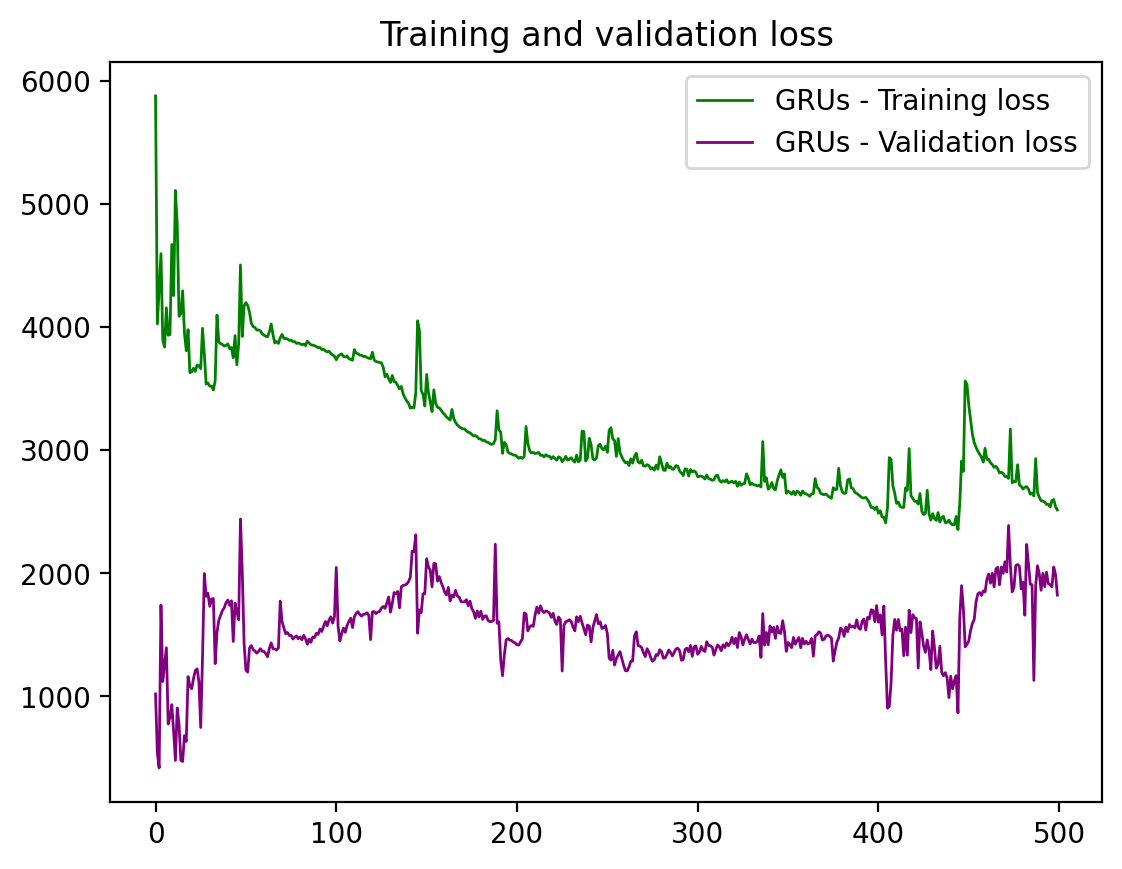

In [ ]:
plot_train_history(history, 'Training and validation loss')



83/83 [==============================] - 0s 3ms/step


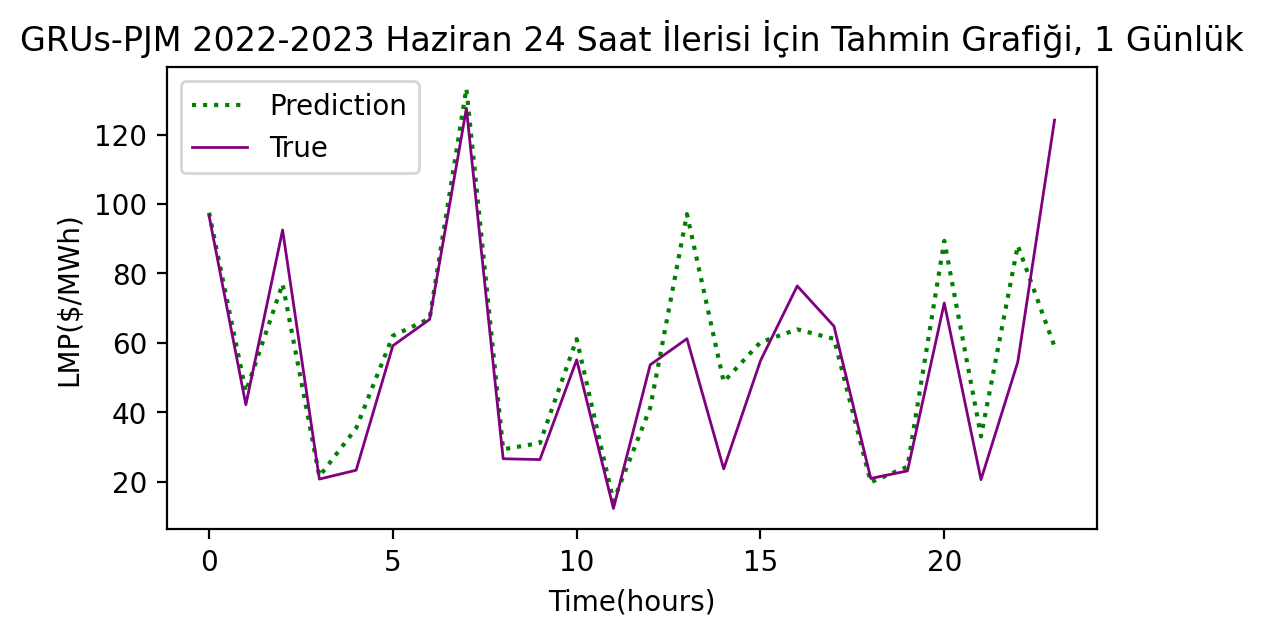

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(6, 3))
y_pred_resized = y_pred[:, -1]
y_test_resized = y_test[:, -1]

plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("GRUs-PJM 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği, 1 Günlük")

hour = 24
n_day = 1
plot_day = hour * n_day
plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted', color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1, color='purple')

plt.legend()
plt.show()

83/83 [==============================] - 0s 3ms/step


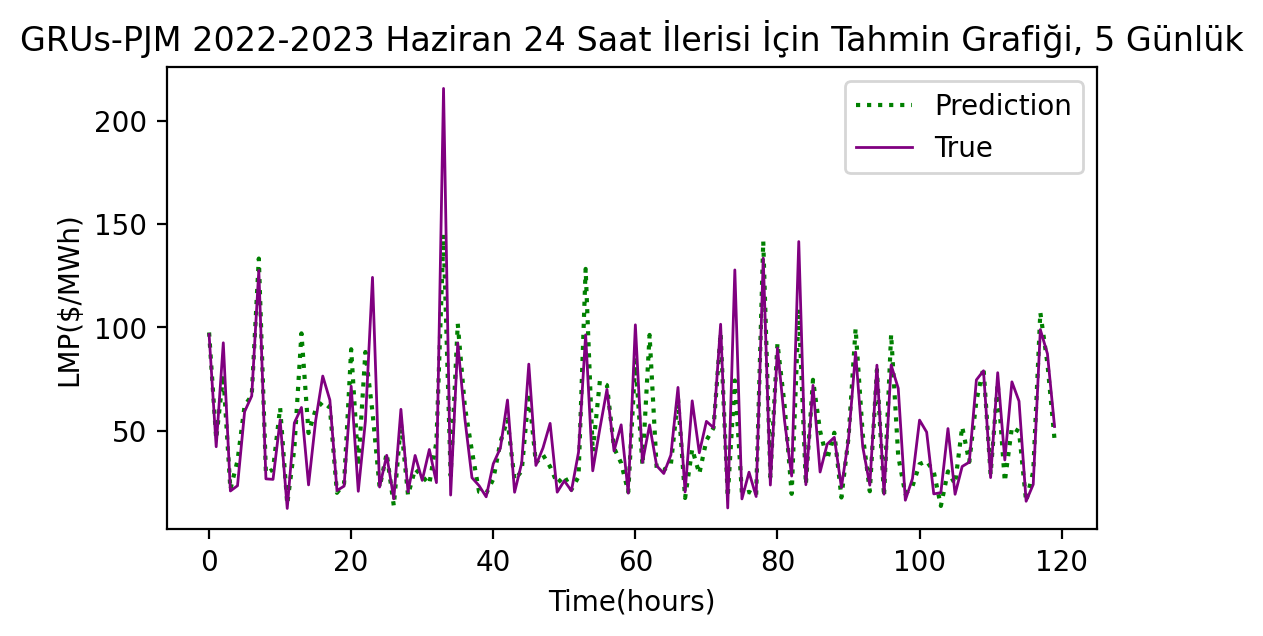

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(6, 3))
y_pred_resized = y_pred[:, -1]
y_test_resized = y_test[:, -1]

plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("GRUs-PJM 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği, 5 Günlük")

hour = 24
n_day = 5
plot_day = hour * n_day
plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted', color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1, color='purple')

plt.legend()
plt.show()

83/83 [==============================] - 0s 3ms/step


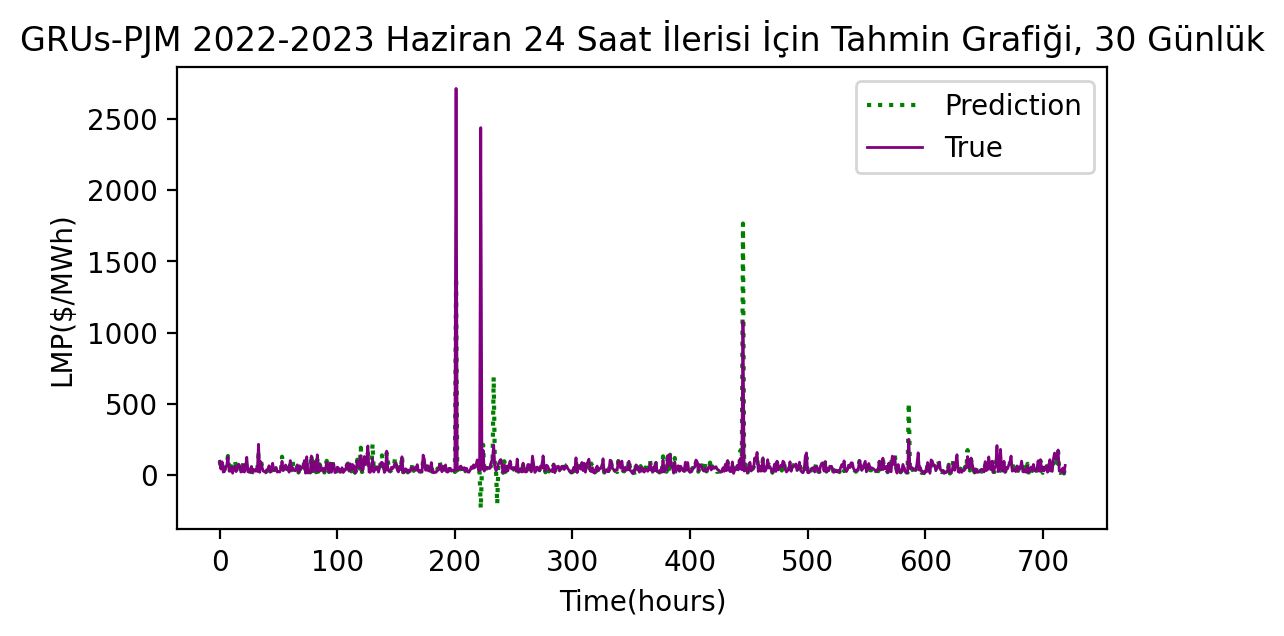

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(6, 3))
y_pred_resized = y_pred[:, -1]
y_test_resized = y_test[:, -1]

plt.xlabel('Time(hours)')
plt.ylabel('LMP($/MWh)')
plt.title("GRUs-PJM 2022-2023 Haziran 24 Saat İlerisi İçin Tahmin Grafiği, 30 Günlük")

hour = 24
n_day = 30
plot_day = hour * n_day
plt.plot(y_pred_resized[0:plot_day], label='Prediction', linestyle='dotted', color='green')
plt.plot(y_test_resized[0:plot_day], label='True', linewidth=1, color='purple')

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

errors = y_pred - y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('Mean Absolute Error: {:.2f}'.format(mae))
print('Root Mean Square Error: {:.2f}'.format(rmse))
print('R2 Score: ', r2_score(y_test, y_pred))

Mean Absolute Error: 15.27
Root Mean Square Error: 75.69
R2 Score:  0.557618516275451
